In [65]:
from PIL import Image
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation, FuncAnimation, ImageMagickFileWriter

from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Div
from bokeh.layouts import row, column
from bokeh.palettes import Colorblind
from  ipywidgets import interact
output_notebook()


Loading BokehJS ...

<font color="red"> text text text </font>

(80, 80, 3)


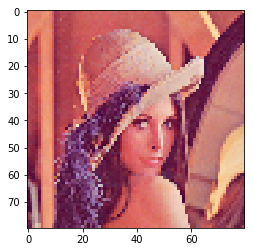

In [66]:
img = Image.open('images/lenna.png')
img = img.resize(size=(80,80))
img_mtx = np.array(img)

print(img_mtx.shape)
plt.imshow(img_mtx)

In this demo we'll use horrifyingly inefficient but (hopefully) easy-to-understand version of discetized reaction-diffusion pde. We'll build a better version later, but for now let's just try to understand what is happening. 

In [67]:
def diffuse(t, x, p):
    """
    t:float:    current time-instance
    x:1D array: flattened vector of state variables ("concentrations")
    p:dict:     parameters
    returns: 1D array, same size as x: flat vector of accumulation terms (dxdt) """
    
    x = x.reshape(p['size'])   # resize flat 1D array back into (height,width,#channels)-array
    dxdt = np.zeros(p['size']) # preallocate the accumulation terms
                
    for r in range(p['size'][0]): # for each row
        for c in range(p['size'][1]): # for each column
            
            # ---get the diffusion term for each species (RGB channel)---
            diffusion = [None]*p['size'][2]
            for i in range(p['size'][2]):
                # left boundary
                if r == 0:
                    diffusion_row = p['D'][i]/p['dr']**2 * (           - x[r,c,i] + x[r+1,c,i])
                # right boundary
                elif r == p['size'][0]-1:
                    diffusion_row = p['D'][i]/p['dr']**2 * (x[r-1,c,i] - x[r,c,i])
                # bulk
                else:
                    diffusion_row = p['D'][i]/p['dr']**2 * (x[r-1,c,i] - 2*x[r,c,i] + x[r+1,c,i])
                # upper boundary
                if c == 0:
                    diffusion_col = p['D'][i]/p['dc']**2 * (           - x[r,c,i] + x[r,c+1,i])
                # lower boundary
                elif c == p['size'][1]-1:
                    diffusion_col = p['D'][i]/p['dc']**2 * (x[r,c-1,i] - x[r,c,i])
                # bulk
                else:
                    diffusion_col = p['D'][i]/p['dc']**2 * (x[r,c-1,i] - 2*x[r,c,i] + x[r,c+1,i])
                
                # total diffusion in two dimensions
                diffusion[i] = diffusion_row + diffusion_col
            
            # ---get the accumulation term = diffusion + reaction---
            # we can use any random reactions for this example, so feel free to change the terms/parameters.
            # the default reactions below can be interpreted as something like:
            # red "preys" on "green" preys on "blue" preys on "red"
            dxdt[r,c,0] = diffusion[0] + p['k3']*x[r,c,0]*x[r,c,1] - p['k1']*x[r,c,2]*x[r,c,0]
            dxdt[r,c,1] = diffusion[1] + p['k2']*x[r,c,1]*x[r,c,2] - p['k4']*x[r,c,0]*x[r,c,1]  
            dxdt[r,c,2] = diffusion[2] + p['k4']*x[r,c,2]*x[r,c,0] - p['k3']*x[r,c,1]*x[r,c,2]

    return dxdt.ravel()

This function calculates the $\frac{dc}{dt}$ term for a single time step. So to find how RGB "concentrations" change over time, we'd need to repeat the same calculation for different time instances. We'll do it using [Euler Forward solver](https://en.wikipedia.org/wiki/Euler_method).

><font size=2>Quick recap: [numerical solutions of ordinary differential equations](recaps/numerical_solutions_recap.ipynb)</font>

In [68]:
def eulerForward(dxdt, x, t_span, p):
    
    x_span = np.zeros((len(x), len(t_span)+1))
    x_span[:,0] = x
    
    for it,t in enumerate(tqdm(t_span)):
        x += dxdt(t, x, p)
        x_span[:,it+1] = x
        
    return x_span[:,:-1]


In [70]:
# run the simulation
# specify time, initial condition and parameters
t0, tf, dt = 0, 10, 0.05
t_span = np.arange(t0,tf+dt,dt)
x0 = img_mtx.ravel()/255    # we'll use the image as initial condition! (flattened and rescaled)
p = {'size': img_mtx.shape, # image size
     'dr': 1,               # step-size in vertical direction (in our case it's just 1 px)
     'dc': 1,               # step-size in horizontal direction
     'D': [0.02, 0.01, 0.03],# diffusion constants for RGB channels
     'k1': 0.20,         # some reaction coefficients
     'k2': 0.15,
     'k3': 0.10,
     'k4': 0.05}

# run the simulation: use Euler Forward to find the RGB "concentrations" numerically
img_development = eulerForward(diffuse, x0, t_span, p)

img_development.shape

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:31<00:00,  6.39it/s]


In [74]:
def convert2img(x, size, slope=5.5, intercept=3):
    # reshape
    x = x.reshape(size)
    
    # rescale into (0,1)
    #x = np.clip(x, 0, 1)
    x = 1/(1 + np.exp(-slope*x+intercept))        
    
    # rescale into (0,255) ints
    x *= 255
    x = x.astype(np.uint8)
    
    # add transparency channel and set each val to 255 (no transparency)
    x = np.concatenate((x, 255*np.ones((size[0], size[1], 1), dtype=np.uint8)), axis=2)
    
    return  x

# plot stuff!
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development.T[0], p['size']))]})

pb = figure(x_range=(0,p['size'][0]), y_range=(0,p['size'][1]),
            plot_width=p['size'][0]*4, plot_height=p['size'][1]*4)
r = pb.image_rgba(image='img', source=img_data, x=0, y=0, dw=p['size'][0], dh=p['size'][1])
show(pb, notebook_handle=True)

# add a slider to check the effect of diffusion over time
def update(slope=5.5, intercept=3):
    r.data_source.data['img'] = [np.flipud(convert2img(img_development.T[0], p['size'], slope=slope, intercept=intercept))]
    push_notebook()
    
interact(update, slope=(-10,10,0.1), intercept=(-10,10,0.1))

interactive(children=(FloatSlider(value=5.5, description='slope', max=10.0, min=-10.0), FloatSlider(value=3.0, description='intercept', max=10.0, min=-10.0), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

In [62]:
# run the simulation
# specify time, initial condition and parameters
t0, tf, dt = 0, 10, 0.05
t_span = np.arange(t0,tf+dt,dt)
x0 = img_mtx.ravel()/255    # we'll use the image as initial condition! (flattened and rescaled)
p = {'size': img_mtx.shape, # image size
     'dr': 1,               # step-size in vertical direction (in our case it's just 1 px)
     'dc': 1,               # step-size in horizontal direction
     'D': [0.02, 0.01, 0.03],# diffusion constants for RGB channels
     'k1': 0.20,         # some reaction coefficients
     'k2': 0.15,
     'k3': 0.10,
     'k4': 0.05}

# run the simulation: use Euler Forward to find the RGB "concentrations" numerically
img_development = eulerForward(diffuse, x0, t_span, p)



# plot stuff!
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development.T[0], p['size']))]})

pb = figure(x_range=(0,p['size'][0]), y_range=(0,p['size'][1]),
            plot_width=p['size'][0]*4, plot_height=p['size'][1]*4)
r = pb.image_rgba(image='img', source=img_data, x=0, y=0, dw=p['size'][0], dh=p['size'][1])
show(pb, notebook_handle=True)

# add a slider to check the effect of diffusion over time
def update(t=0):
    i = int(t/dt)
    r.data_source.data['img'] = [np.flipud(convert2img(img_development.T[i], p['size']))]
    push_notebook()
    
interact(update, t=(t0,tf,dt))

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:32<00:00,  6.15it/s]


interactive(children=(FloatSlider(value=0.0, description='t', max=10.0, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

### Converting frames to mp4

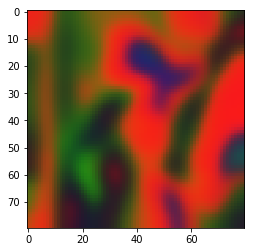

In [54]:
fig = plt.figure()
imgs = [[plt.imshow(convert2img(img_development.T[i], p['size']), animated=True)]
         for i in range(len(t_span))]
gif = ArtistAnimation(fig, imgs, interval=100, blit=True, repeat_delay=1000)
gif.save('images\img_reaction_diffusion.mp4')
plt.show()

In [58]:
%%HTML
<iframe height="300" width="400" src="images/img_reaction_diffusion.mp4"></iframe>